In [83]:
import pandas as pd
import seaborn as sns
import sys
import matplotlib.pyplot as plt
from sklearn import linear_model

sys.path.append("..")

from utils import get_def_player_stats, get_players_info

In [84]:
# Confirm that 'UFA'
de_df = get_def_player_stats(list(range(1999, 2025)))
players = get_players_info()
de_df["status"] = de_df["player_id"].map(
    players.set_index("gsis_id")["status"], na_action="ignore"
)
de_df[de_df['status'] == 'UFA']['season'].max()

2020

Empty DataFrame
Columns: [season, week, season_type, player_id, player_name, player_display_name, position, position_group, headshot_url, team, def_tackles, def_tackles_solo, def_tackles_with_assist, def_tackle_assists, def_tackles_for_loss, def_tackles_for_loss_yards, def_fumbles_forced, def_sacks, def_sack_yards, def_qb_hits, def_interceptions, def_interception_yards, def_pass_defended, def_tds, def_fumbles, def_fumble_recovery_own, def_fumble_recovery_yards_own, def_fumble_recovery_opp, def_fumble_recovery_yards_opp, def_safety, def_penalty, def_penalty_yards]
Index: []

[0 rows x 32 columns]


/var/folders/4b/7v01nk757qsbhc05_11mrdnr0000gn/T/ipykernel_37013/2026925535.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_df["num_seasons"] = [len(v) for v in season_group.groups.values()]
/var/folders/4b/7v01nk757qsbhc05_11mrdnr0000gn/T/ipykernel_37013/2026925535.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  de_df["status"] = de_df["player_id"].map(


Empty DataFrame
Columns: [player_id, player_display_name, def_sacks, def_tackles, def_tackles_for_loss, def_tackles_for_loss_yards, def_qb_hits, def_tackles_solo, def_tackles_with_assist, def_tackle_assists, def_fumbles_forced, def_sack_yards, def_interceptions, def_interception_yards, def_pass_defended, def_tds, def_fumbles, def_fumble_recovery_own, def_fumble_recovery_yards_own, def_fumble_recovery_opp, def_fumble_recovery_yards_opp, def_safety, def_penalty, def_penalty_yards, week, season, num_seasons, status, entry_year]
Index: []

[0 rows x 29 columns]
4175     0.0
5145     0.0
5162     0.0
5475     0.0
5820     0.0
        ... 
12189    0.0
12245    0.0
12332    0.0
12545    0.0
13435    0.0
Length: 163, dtype: float64


<Axes: >

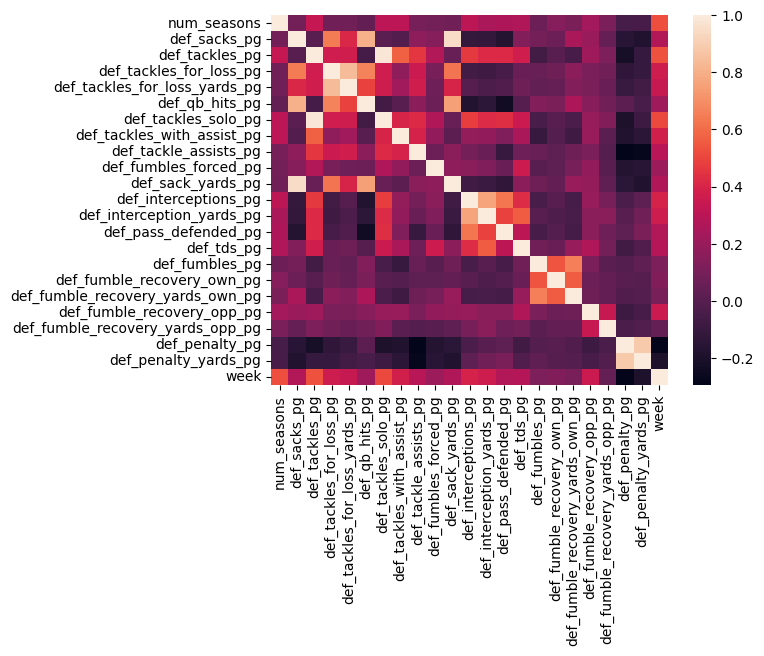

In [ ]:
agg_dict = {
    "player_display_name": "max",
    "def_sacks": "sum",
    "def_tackles": "sum",
    "def_tackles_for_loss": "sum",
    "def_tackles_for_loss_yards": "sum",
    "def_qb_hits": "sum",
    "def_tackles_solo": "sum",
    "def_tackles_with_assist": "sum",
    "def_tackle_assists": "sum",
    "def_fumbles_forced": "sum",
    "def_sack_yards": "sum",
    "def_interceptions": "sum",
    "def_interception_yards": "sum",
    "def_pass_defended": "sum",
    "def_tds": "sum",
    "def_fumbles": "sum",
    "def_fumble_recovery_own": "sum",
    "def_fumble_recovery_yards_own": "sum",
    "def_fumble_recovery_opp": "sum",
    "def_fumble_recovery_yards_opp": "sum",
    "def_safety": lambda x: x.sum(skipna=True),
    "def_penalty": "sum",
    "def_penalty_yards": "sum",
    "week": "count",
    "season": "min",
    "num_seasons": "max",
}

de_df = get_def_player_stats(list(range(1999, 2025)))
de_df = de_df[
    (de_df["season_type"] == "REG")
    & (
        de_df["position"].isin(
            ["LB", "DL", "DT", "DB", "SS", "CB", "SAF", "NT", "ILB", "FS"]
        )
    )
]
print(de_df[de_df["def_safety"].isna()])
players_with_two_seasons = de_df.groupby(["player_id"])["season"].nunique()
players_with_two_seasons = players_with_two_seasons[players_with_two_seasons > 1]
de_df["num_seasons"] = de_df["season"]
group = de_df[
    (de_df["player_id"].isin(players_with_two_seasons.index.to_list()))
].groupby(["player_id", "season"], as_index=False)
de_df = group.agg(agg_dict)
season_group = de_df.groupby("player_id", as_index=False)
de_df = season_group.nth(1)
de_df["num_seasons"] = [len(v) for v in season_group.groups.values()]

# Report on DF Stats
# print(de_df[de_df['player_id'].isna()].count())

# Add Player Meta Info
players = get_players_info()
de_df["status"] = de_df["player_id"].map(
    players.set_index("gsis_id")["status"], na_action="ignore"
)
de_df = de_df[
    ((de_df["status"] == "ACT") & de_df["num_seasons"] > 12)
    | (de_df["status"].isin(["RET", "UFA"]))
]
de_df["entry_year"] = de_df["player_id"].map(
    players.set_index("gsis_id")["entry_year"], na_action="ignore"
)
# It seems that most players with no entry year would be missing some seasons anyways
# so dropping that here is ok
de_df = de_df[de_df["entry_year"].notna()]
print(de_df[de_df["def_safety"].isna()])
## Normalize the stats per game and let # of games be a feature on its own

de_df["def_sacks_pg"] = de_df["def_sacks"] / de_df["week"]
de_df["def_tackles_pg"] = de_df["def_tackles"] / de_df["week"]
de_df["def_tackles_for_loss_pg"] = de_df["def_tackles_for_loss"] / de_df["week"]
de_df["def_tackles_for_loss_yards_pg"] = (
    de_df["def_tackles_for_loss_yards"] / de_df["week"]
)
de_df["def_qb_hits_pg"] = de_df["def_qb_hits"] / de_df["week"]
de_df["def_tackles_solo_pg"] = de_df["def_tackles_solo"] / de_df["week"]
de_df["def_tackles_with_assist_pg"] = de_df["def_tackles_with_assist"] / de_df["week"]
de_df["def_tackle_assists_pg"] = de_df["def_tackle_assists"] / de_df["week"]
de_df["def_fumbles_forced_pg"] = de_df["def_fumbles_forced"] / de_df["week"]
de_df["def_sack_yards_pg"] = de_df["def_sack_yards"] / de_df["week"]
de_df["def_interceptions_pg"] = de_df["def_interceptions"] / de_df["week"]
de_df["def_interception_yards_pg"] = de_df["def_interception_yards"] / de_df["week"]
de_df["def_pass_defended_pg"] = de_df["def_pass_defended"] / de_df["week"]
de_df["def_tds_pg"] = de_df["def_tds"] / de_df["week"]
de_df["def_fumbles_pg"] = de_df["def_fumbles"] / de_df["week"]
de_df["def_fumble_recovery_own_pg"] = de_df["def_fumble_recovery_own"] / de_df["week"]
de_df["def_fumble_recovery_yards_own_pg"] = (
    de_df["def_fumble_recovery_yards_own"] / de_df["week"]
)
de_df["def_fumble_recovery_opp_pg"] = de_df["def_fumble_recovery_opp"] / de_df["week"]
de_df["def_fumble_recovery_yards_opp_pg"] = (
    de_df["def_fumble_recovery_yards_opp"] / de_df["week"]
)
print(de_df["def_safety"] / de_df["week"])
de_df["def_safety_pg"] = de_df["def_safety"] / de_df["week"]
de_df["def_penalty_pg"] = de_df["def_penalty"] / de_df["week"]
de_df["def_penalty_yards_pg"] = de_df["def_penalty_yards"] / de_df["week"]
de_df = de_df[
    [
        "num_seasons",
        "player_id",
        "player_display_name",
        "def_sacks_pg",
        "def_tackles_pg",
        "def_tackles_for_loss_pg",
        "def_tackles_for_loss_yards_pg",
        "def_qb_hits_pg",
        "def_tackles_solo_pg",
        "def_tackles_with_assist_pg",
        "def_tackle_assists_pg",
        "def_fumbles_forced_pg",
        "def_sack_yards_pg",
        "def_interceptions_pg",
        "def_interception_yards_pg",
        "def_pass_defended_pg",
        "def_tds_pg",
        "def_fumbles_pg",
        "def_fumble_recovery_own_pg",
        "def_fumble_recovery_yards_own_pg",
        "def_fumble_recovery_opp_pg",
        "def_fumble_recovery_yards_opp_pg",
        # "def_safety_pg", All zeroes
        "def_penalty_pg",
        "def_penalty_yards_pg",
        "week",
    ]
]
sns.heatmap(de_df.drop(columns=["player_display_name", "player_id"]).corr())
for col in de_df.columns:
    if col.endswith("_pg"):
        de_df[col] = de_df[col].fillna(0)

In [86]:
de_df = get_def_player_stats(list(range(1999, 2025)))
de_df['post_season_games'] = de_df[(de_df["season_type"] == "POST")]
de_df = de_df.rename(columns={"week": "games"})

players_df = get_players_info()
de_df["birth_date"] = de_df["player_id"].map(
    players_df.set_index("gsis_id")["birth_date"], na_action="ignore"
)
de_df["entry_year"] = de_df["player_id"].map(
    players_df.set_index("gsis_id")["entry_year"], na_action="ignore"
)
# Only include players who started their career in the window of data
de_df = de_df[de_df['entry_year'] > 1998]
de_df = de_df[de_df["birth_date"].notna()]
de_df["age"] = de_df["season"] - pd.DatetimeIndex(de_df["birth_date"]).year
de_df = de_df[
    [
        "player_id",
        "season",
        "games",
        "player_display_name",
        "def_tackles",
        "def_sacks",
        "def_tackles_for_loss",
        "def_qb_hits",
        "age",
    ]
]
de_df

de_df = de_df.groupby(["player_id", "season"]).agg(
    {
        "player_display_name": "max",
        "age": "max",
        "games": "count",
        "def_sacks": "sum",
        "def_tackles": "sum",
        "def_tackles_for_loss": "sum",
        "def_qb_hits": "sum",
    }
)

ValueError: Cannot set a DataFrame with multiple columns to the single column post_season_games